<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395 Redes Neuronales Artificiales 2019-1</h1>

<H3 align='center'> Tarea 1 - Redes Neuronales y *Deep Learning* </H3>
<hr style="height:2px;border:none"/>

## Integrantes

* _**Francisco Olivares - 201473575-8 - fracisco.olivars.14@sansano.usm.cl**_
* _**Gabriel Valenzuela - 201473505-7 - gabriel.valenzuel.14@sansano.usm.cl**_
* _**Felipe Vega - 201473511-1 - felipe.vega.14@sansano.usm.cl**_



<hr style="height:2px;border:none"/>

In [1]:
#Soy tu bloque pa' los imports papi
#Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact 


#Sklearn stuff
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

#Keras stuff
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD

#Que se vea ancho el jupyter
from IPython.display import IFrame
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))


#Cantidad de columnas a mostrar con pandas
pd.set_option('display.max_columns',100)

Using TensorFlow backend.


<hr style="height:2px;border:none"/>

# Red neuronal Feed Forward para detectar Exoplanetas

Para comenzar, se cargarán los datos necesarios, los cuales tienen features extraidas a partir de las curvas de luz (intensidad de la luz en el tiempo) y metadatos de la observación [continuar con el relleno].

Desde el archivo _**koi sets unb**_ se obtiene el conjunto al que pertenece cada dato, los cuales pueden ser Test, Train y Unlabeled. Desde _**koi light curves**_ se obtienen las features extraidas a partir de las curvas de luz y los metadatos de la observación. Finalmente, desde _**koi labels**_ se obtendrán las etiquetas de cada exoplaneta, las cuales son _**CONFIRMED**_ o _**FALSE POSITIVE**_.

In [2]:
df_sets = pd.read_csv("data/koi_sets_unb.csv")

mask_train = (df_sets["Set"] == "Train").values
mask_test = (df_sets["Set"] == "Test").values

df_labels = pd.read_csv("data/koi_labels.csv")
df_X = pd.read_csv("data/koi_light_curves_X.csv")
df_labels_train = df_labels[mask_train]
df_labels_test = df_labels[mask_test]
df_X_train = df_X[mask_train]
df_X_test = df_X[mask_test]

Con los datos ya cargados, se generan las matrices para los conjuntos de entrenamiento y pruebas, como también se generan una etiqueta binaria para cada dato. Se realizar un boxplot para cada columna con datos numéricos, para observar la existencia de outliers.


In [3]:
y_train = ((df_labels_train["NExScI Disposition"]=="CONFIRMED")*1).values
y_test = ((df_labels_test["NExScI Disposition"]=="CONFIRMED")*1).values
df_X_train = df_X_train.reset_index(drop=True)
df_X_test = df_X_test.reset_index(drop=True)

In [4]:
def boxplotPlotTrain(column_name = 'Mean'):
    plt.figure()
    plt.title("Boxplot of "+column_name)
    plt.boxplot(df_X_train[column_name])
    plt.show()
    
numeric_columns = []
for i in df_X_train.columns:
    if np.issubdtype(df_X_train[i].dtype,np.number):
        numeric_columns.append(i)  
        
interact(boxplotPlotTrain, column_name=numeric_columns)        

interactive(children=(Dropdown(description='column_name', index=2, options=('Minimum', 'Maximum', 'Mean', 'Std…

<function __main__.boxplotPlotTrain(column_name='Mean')>

Se observa la presencia de outliers en la gran mayoría de los datos numéricos. Dado lo anterior, se toma la decisión que si existen datos nulos se reemplazarán con la mediana, dado que es un estadístico robusto frente outliers. 

In [5]:
df_X_train.fillna(df_X_train.median(), inplace=True)
df_X_test.fillna(df_X_test.median(), inplace=True)
X_train = df_X_train.values[:,1:]
X_test = df_X_test.values[:,1:]

> _**a) Explore los datos trabajados, ya sea con estadísticos simples o con gráficos como histogramas y/o boxplots. Comente sobre el problema enfrentado, es decir, la tarea de transformar un vector  𝑋  en un valor categórico (0 o 1).**_

El dataset cuenta con 41 atributos, cuyos nombres se presentan a continuación, 

In [6]:
columns_names = df_X_train.columns[1:]
columns_names

Index(['Minimum', 'Maximum', 'Mean', 'Std', 'IQR', 'Skew', 'Kurtosis', 'Q1',
       'Q2', 'Slope', 'Amplitude', 'MAD', 'Residual Bright Faint Ratio',
       'Median', 'Period', 'Time of Transit Epoch', 'First Transit Time (BJD)',
       'Impact Parameter', 'Duration', 'Transit Depth', 'r/R',
       'Fitted Stellar Density', 'Planet Radius', 'Semi-major Axis',
       'Inclination', 'Teq', 'Insolation Flux', 'a/R', 'Limb Darkening Coeff1',
       'Limb Darkening Coeff2', 'Limb Darkening Coeff3',
       'Limb Darkening Coeff4', 'Teff', 'log(g)', 'Metallicity',
       'Stellar Radius', 'Stellar Mass', 'Max single event sigma',
       'Max Multievent sigma', 'Transit Model SNR', 'KOI count'],
      dtype='object')

In [7]:
print(X_train.shape)
print(X_test.shape)


(4692, 41)
(1565, 41)


El conjunto de entrenamiento cuenta con 4692 registros, mientras que el conjunto de pruebas cuenta con 1565 registros.

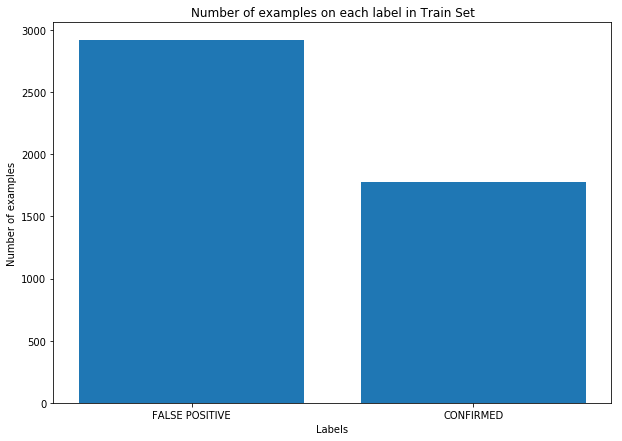

In [8]:
plt.figure(figsize=(10,7))
plt.title("Number of examples on each label in Train Set")
plt.bar(['0','1'],[len(y_train)-y_train.sum(),y_train.sum()])
plt.xlabel("Labels")
plt.ylabel("Number of examples")
plt.xticks([0,1],['FALSE POSITIVE','CONFIRMED'])
plt.show()

Se observa que las etiquetas del conjunto de entrenamiento se encuentran desbalanceadas, por que se espera que la red tienda a clasificar cada registro como FALSE POSITIVE, pues eso minimizaría su probabilidad de equivocarse. Por lo anterior, al momento de evaluar el desempeño de la red se debe considerar además otra métrica distinta de la _accuracy_, como el _F1 Score_.

A continuación se presentan distintos estadísticos para cada uno de los atributos

In [9]:
df_X_train.describe()

,Minimum,Maximum,Mean,Std,IQR,Skew,Kurtosis,Q1,Q2,Slope,Amplitude,MAD,Residual Bright Faint Ratio,Median,Period,Time of Transit Epoch,First Transit Time (BJD),Impact Parameter,Duration,Transit Depth,r/R,Fitted Stellar Density,Planet Radius,Semi-major Axis,Inclination,Teq,Insolation Flux,a/R,Limb Darkening Coeff1,Limb Darkening Coeff2,Limb Darkening Coeff3,Limb Darkening Coeff4,Teff,log(g),Metallicity,Stellar Radius,Stellar Mass,Max single event sigma,Max Multievent sigma,Transit Model SNR,KOI count
count,4692.000000,4692.000000,4692.000000,4692.000000,4692.000000,4692.000000,4692.000000,4692.000000,4692.000000,4.692000e+03,4692.000000,4692.000000,4692.000000,4692.000000,4692.000000,4692.000000,4.692000e+03,4692.000000,4692.000000,4692.000000,4692.000000,4692.000000,4692.000000,4692.000000,4692.000000,4692.000000,4.692000e+03,4692.000000,4692.000000,4692.000000,4692.0,4692.0,4692.000000,4692.000000,4692.000000,4692.000000,4692.000000,4692.000000,4692.000000,4692.000000,4692.000000
mean,-66.492676,23.987692,-0.142418,4.136842,0.333109,-9.386612,211.410321,-0.105753,0.017978,1.483853e-07,45.240184,0.147191,103.043248,0.017978,39.181997,159.105302,2.454992e+06,0.664878,5.786126,40197.917882,0.211793,3.246083,40.520243,0.162023,80.784582,1219.953751,1.104767e+04,37.746210,0.404140,0.255844,0.0,0.0,5744.338875,4.296402,-0.132632,1.900540,1.036185,287.105781,1676.133027,433.699680,1.460358
std,274.391875,112.019945,0.501607,18.127797,2.060592,9.112166,539.593897,0.450513,0.366224,7.449019e-06,190.309298,0.862019,153.443064,0.366224,94.453978,61.608967,6.160896e+01,0.934906,7.185999,105008.944336,0.856294,20.059514,405.813248,0.252837,16.700814,950.878177,1.931656e+05,88.758042,0.108433,0.065967,0.0,0.0,860.487363,0.457178,0.283833,7.311725,0.372291,1001.727968,5421.050203,1052.012721,0.950673
min,-8446.637695,0.000000,-13.658888,0.000000,0.000000,-117.225060,-3.000000,-11.479470,-1.961110,-1.280449e-04,0.000000,0.000000,1.032485,-1.961110,0.299698,120.565925,2.454954e+06,0.000000,0.296100,0.800000,0.001000,0.000040,0.080000,0.006000,5.260000,92.000000,2.000000e-02,1.006000,0.128000,-0.121000,0.0,0.0,2703.000000,0.047000,-1.980000,0.118000,0.000000,2.539000,7.105000,0.000000,1.000000
25%,-7.086795,0.167940,-0.028155,0.051691,0.002100,-11.797075,17.711536,-0.014000,-0.001772,-3.708501e-08,0.418177,0.000670,22.901289,-0.001772,2.068399,132.467184,2.454965e+06,0.248000,2.599597,206.600000,0.014000,0.177645,1.600000,0.032000,81.320000,614.000000,3.351750e+01,4.090000,0.324000,0.229000,0.0,0.0,5332.000000,4.192750,-0.280000,0.832750,0.849000,4.317000,13.582000,18.300000,1.000000
50%,-1.620665,0.439595,-0.008431,0.105266,0.009035,-6.907724,58.183594,-0.003770,0.000000,0.000000e+00,1.056900,0.004060,54.585001,0.000000,7.096163,135.694975,2.454969e+06,0.618000,3.984500,622.200000,0.027000,0.719020,2.970000,0.072000,87.820000,981.000000,2.208000e+02,11.720000,0.386000,0.273000,0.0,0.0,5780.000000,4.432000,-0.100000,1.001000,0.974000,6.592500,27.682000,39.100000,1.000000
75%,-0.643782,2.028700,-0.002930,0.411105,0.028001,-3.781710,170.416851,-0.000190,0.000000,4.254584e-08,4.523286,0.011992,118.101057,0.000000,23.561688,162.886710,2.454996e+06,0.922250,6.240750,6538.950000,0.261000,2.204478,33.412500,0.159000,89.520000,1558.000000,1.420352e+03,31.092500,0.460000,0.302000,0.0,0.0,6137.000000,4.539000,0.070000,1.392000,1.107000,52.505750,272.439000,201.150000,2.000000
max,0.000000,3780.657715,0.000000,686.443909,76.330341,16.964659,16951.279152,5.092345,15.002840,1.998463e-04,5550.700195,28.998531,2709.687200,15.002840,1071.232624,1472.522306,2.456306e+06,25.224000,138.540000,921671.000000,24.663000,839.902280,26042.900000,2.152000,90.000000,14667.000000,1.094755e+07,1603.000000,0.944000,0.464000,0.0,0.0,15896.000000,5.274000,0.560000,229.908000,3.735000,22982.162000,120049.680000,9054.700000,7.000000


Se observan grandes diferencias entre el mínimo y el segundo cuartil, como también entre el máximo y el tercer cuartil, lo que concuerda con lo mostrado por los boxplots anteriores. También se ven las diferencias entre la media y la mediana, lo que refuerza la decisión de usar un estadístico robusto frente a outliers.

Se genera un histograma y un boxplot para cada una de las columnas en ambos dataset.

In [10]:
def histAndBoxplot(column_name='Minimum', dataset='Train'):
    if(dataset=='Train'):
        df = df_X_train
    else:
        df = df_X_test
    plt.figure(figsize=(15,7))    
    plt.subplot(121)
    plt.title("Histogram of "+ column_name)
    plt.hist(df[column_name])
    plt.subplot(122)
    plt.title("Boxplot of " + column_name)
    plt.boxplot(df[column_name])
    plt.show()
    

In [11]:
interact(histAndBoxplot,column_name = columns_names,dataset=['Train','Test'])

interactive(children=(Dropdown(description='column_name', options=('Minimum', 'Maximum', 'Mean', 'Std', 'IQR',…

<function __main__.histAndBoxplot(column_name='Minimum', dataset='Train')>

Se observa una gran cantidad de outliers en casi todos los atributos. Una posible decisión sería eliminar algunos de ellos, pero como no se tienen conocimientos astronómicos sobre Exoplanetas se prefiere mantenerlos en el dataset, pues podrían ser elementos específicos de cierto tipo de objetos astronómicos.

El problema a enfrentar es el de clasificación entre dos clases mutuamente excluyentes. Por lo tanto, a partir de un vector se debe obtener un valor categórico, lo que de utilizar Redes Neuronales Feed Forward se puede lograr mediante la aplicación de transformaciones entre capas de neuronas, donde finalmente la capa de salida cuente solo con dos neuronas, cuyo resultado de computo entregará la probabilidad de pertenecer a cierta etiqueta o no. Al ser etiquetaas mutuamente excluyentes se debe utilizar una función de activación adecuada, como por ejemplo la función Soft-Max, lo que entregará ambos resultados entre 0 o 1, donde además la suma entre ellos da 1. Finalmente, para entregar un valor entre 0 y 1, se determina cual de las probabilidades entregadas es mayor, y en función de eso se retorna la etiqueta de la clase requerida.

Cabe destacar que para resolver este tipo de problemas se busca aproximar $P(y|x)$, es decir, la pertenencia a una determinada clase dado un ejemplo en específico. Por lo anterior, se requiere utilizar una función de perdida adecuada en el entrenamiento, como por ejemplo la Cross-Entropy Loss, la cual calcula las divergencias entre la función de probabilidad que se desea aproximar y la aproximación. Acá surge un nuevo problema en este caso, pues al tener clases desbalanceadas el clasificador tenderá a clasificar un mayor cantidad de ejemplos con la etiqueta de la clase dominante, debido a que la Cross-Entropy Loss funciona en base a _*accuracy*_, y al clasificar todo con la etiqueta de la clase dominante este valor tendería a ser más alto si es desbalance es demasiado. [REVISAR EL CHAMUYO OE ZI]


> _**b) Escale los datos para ser trabajados por el modelo de aprendizaje, indique la importancia de éste paso. Además cree un conjunto de validación extrayendo un cierto porcentaje del conjunto de entrenamiento, por ejemplo el 20% manteniendo el desbalanceo de clases (split stratificado).**_

Se escalan los datos antes de trabajarlos con el modelo de aprendizaje, este paso es importante, pues al tener columnas con datos de distintas magnitudes, el modelo mayor importancia a aquellos atributos con magnitud más grande. En el caso de las Redes Neuronales Feed Forward, al momento de calcular la activación de cada capa. 

$$ a_i = \sigma\left( W_{i}^{T} \cdot a_{i-1} + b_{i}\right)$$

Al tener elementos con magnitudes más grandes afectarían directamente a las activaciones de las capas siguientes, por lo que un buen escalamiento de datos se hace realmente importante.

Además se separa un conjunto de validación, considerando un 20$\%$ de los datos del conjunto de entrenamiento, con el objetivo de usar dicho conjunto como un predictor del comportamiento en el conjunto de pruebas.

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2,stratify=y_train,random_state=42)
print("Shape of X_train "+str(np.shape(X_train)))
print("Shape of X_val "+str(np.shape(X_val)))

Shape of X_train (3753, 41)
Shape of X_val (939, 41)


In [13]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled =  scaler.transform(X_test)

c:\mauro\redesn~1\env\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
c:\mauro\redesn~1\env\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
c:\mauro\redesn~1\env\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
c:\mauro\redesn~1\env\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


> _**c) Muestre en un gráfico la función objetivo (cross entropy) para el conjunto de entrenamiento y de validación vs número de epochs de entrenamiento, para una red feedforward de 3 capas, con 256 unidades ocultas y función de activación sigmoidal. Entrene la red usando gradiente descendente estocástico con tasa de aprendizaje (learning rate) 0.01 y 100 epochs de entrenamiento. Comente. Si observa divergencia durante el entrenamiento, determine si esto ocurre para cada repetición del experimento. Compare el efecto de variar la función de activación a ReLU ¿Qué observa en la convergencia del modelo?**_

Se entrenan dos redes distintas, una con función de activación sigmoidal y la otra con función de activación Relu. Para cada red se grafica el valor de su Loss Function en cada Epoch para los conjuntos de entrenamiento y validación. Como se está utilizando gradiente descendente estocástico, se repite el experiento 10 veces.

In [14]:
hist_list = []
hist_list_relu = []
epoch_list = [x for x in range(1,101)]
for i in range(10):
    model = Sequential()
    model.add(Dense(256, input_dim=X_train_scaled.shape[1],kernel_initializer='uniform',activation='sigmoid'))
    model.add(Dense(1, kernel_initializer='uniform',activation="sigmoid"))
    model.compile(optimizer=SGD(lr=0.01),loss='binary_crossentropy')
    hist_list.append(model.fit(X_train_scaled,y_train,epochs=100,verbose=0,validation_data=(X_val_scaled,y_val)))
  
    model = Sequential()
    model.add(Dense(256, input_dim=X_train_scaled.shape[1],kernel_initializer='uniform',activation='relu'))
    model.add(Dense(1, kernel_initializer='uniform',activation="relu"))
    model.compile(optimizer=SGD(lr=0.01),loss='binary_crossentropy')
    hist_list_relu.append(model.fit(X_train_scaled,y_train,epochs=100,verbose=0,validation_data=(X_val_scaled,y_val)))

Las redes entrenadas tienen la siguiente arquitectura

In [21]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 256)               10752     
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 257       
Total params: 11,009
Trainable params: 11,009
Non-trainable params: 0
_________________________________________________________________


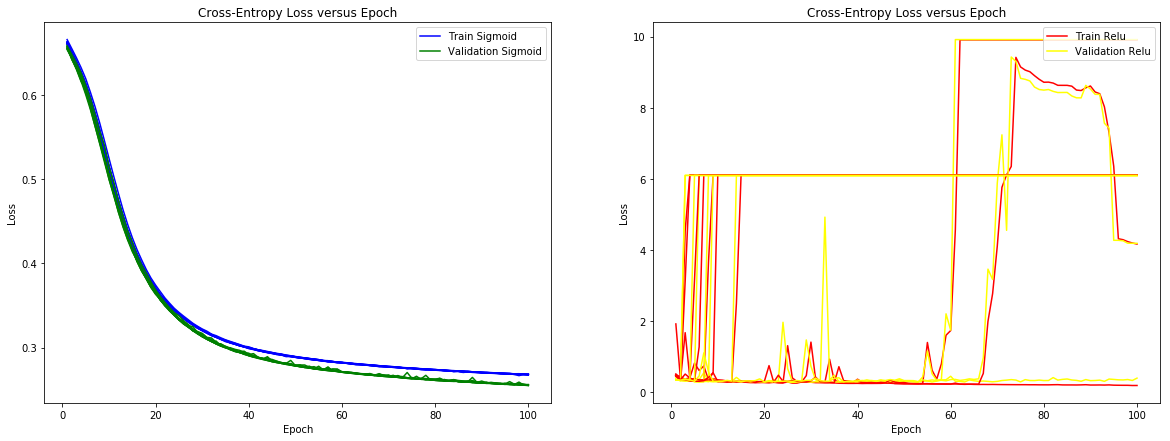

In [15]:
plt.figure(figsize=(20,7))
plt.subplot(121)
plt.title('Cross-Entropy Loss versus Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')


for i in hist_list:
    plt.plot(epoch_list,i.history['loss'],color='blue')
    plt.plot(epoch_list,i.history['val_loss'],color='green')

plt.legend(['Train Sigmoid','Validation Sigmoid'],loc='upper right')
  
plt.subplot(122)
plt.title('Cross-Entropy Loss versus Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')

for j in hist_list_relu:
    plt.plot(epoch_list,j.history['loss'],color='red')
    plt.plot(epoch_list,j.history['val_loss'],color='yellow')

plt.legend(['Train Relu','Validation Relu'],loc='upper right')
plt.show()  


En el caso de las redes con activación sigmoidal, en los 25 experimentos se observa convergencia en el entrenamiento, además no se observa overfitting. En el caso de las redes con activacion ReLu, se observa divergencia en gran parte de los experimentos. Esto probablemente se deba a que la función rectificadora no está acotada por la derecha, por lo que es probable que eso afecte en las predicciones del modelo mientras se entrena.

> _**Finalmente compare a través de una métrica de desempeño sobre el conjunto de pruebas, en este caso como trabajamos un problema desbalanceado, mida f1 score weighted, comente sobre esta decisión ¿Es esperable la diferencia entre relu y sigmoidal en base a los gráficos realizados?**_

Para evaluar ambas redes se utiliza el f1 score, el cual trata de considerar la _**accuracy**_ y el _**recall**_. La precisión, en un problema de clasificación binario, se puede ver como la razón entre los verdaderos positivos y todos los valores entregados como positivos por el modelo. El recall en cambio, se puede ver como la razón entre los verdaderos positivos entre todos los valores verdaderos del conjunto. En problemas desbalanceados, si se considera solo la accuracy para evaluar los distintos modelos, se tenderá a elegir un modelo que clasifique la gran mayoría de los datos con los valores de la clase dominante, en cambio si se utiliza solo el recall para elegir el modelo, dicho modelo tenderá a clasificar todos los catos como la clase menos representada. Es por lo anterior que se utiliza el F1-Score, pues considera la media armónica entre ambas métricas.

$$ F1_{score} = 2\cdot\frac{precision \cdot recall}{precision + recall}$$

Considerando los gráficos anteriores de ambas redes, es de esperar que la red con activación sigmoidal obtenga mejores resultados. Pues en el caso de la red con activación Relu, si se observa que el valor de la Loss es muy alto es porque $P(y|x)$ y $f(x)$ divergen mucho entre si.

In [16]:
model_sigmoid = Sequential()
model_sigmoid.add(Dense(256, input_dim=X_train_scaled.shape[1],kernel_initializer='uniform',activation='sigmoid'))
model_sigmoid.add(Dense(1, kernel_initializer='uniform',activation="sigmoid"))
model_sigmoid.compile(optimizer=SGD(lr=0.01),loss='binary_crossentropy')
model_sigmoid.fit(X_train_scaled,y_train,epochs=100,verbose=0,validation_data=(X_val_scaled,y_val))

model_relu = Sequential()
model_relu.add(Dense(256, input_dim=X_train_scaled.shape[1],kernel_initializer='uniform',activation='relu'))
model_relu.add(Dense(1, kernel_initializer='uniform',activation="relu"))
model_relu.compile(optimizer=SGD(lr=0.01),loss='binary_crossentropy')
model_relu.fit(X_train_scaled,y_train,epochs=100,verbose=0,validation_data=(X_val_scaled,y_val))

In [17]:
f1_score_sigmoid = f1_score(y_test,model_sigmoid.predict_classes(X_test_scaled),average='weighted')
f1_score_relu = f1_score(y_test,model_relu.predict_classes(X_test_scaled),average='weighted')

print("F1 Score Sigmoid: "+str(f1_score_sigmoid))
print("F1 Score Relu: "+str(f1_score_relu))

1248/1565 [======================>.......] - ETA: 0s F1 Score Sigmoid: 0.8401314633726691
F1 Score Relu: 0.5470135402403773


c:\mauro\redesn~1\env\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Como era de esperar, la red con función de activación sigmoidal obtiene un F1-Score mejor que la red con función de activación Relu.

> _**d) Repita c) variando la tasa de aprendizaje (learning rate) en un rango sensible. Comente. Si observa divergencia durante el entrenamiento, determine si esto ocurre para cada repetición del experimento o para alguna de las dos funciones de activación experimentadas.**_

Se utilizan 20 learning rates distintas, en un rango entre 0 y 1, para las redes entrenadas anteriormente. Por cada learning rate se entrenan 3 redes por cada función de activación, lo anterior por un tema de tiempo de entrenamiento, pues finalmente se terminan entrenando 120 redes.  

In [18]:
n_lr = 20
learn_rate = np.linspace(0,1,n_lr)

lr_sigmoid_dict = dict()
lr_relu_dict = dict()
model_sigmoid_dict = dict()
model_relu_dict = dict()
for lr in learn_rate:
    sigmoid_list = []
    relu_list = []
    for i in range(3):
    # Training FF with sigmoid activation
        model_sigmoid = Sequential()
        model_sigmoid.add(Dense(256, input_dim=X_train_scaled.shape[1],kernel_initializer='uniform',activation='sigmoid'))
        model_sigmoid.add(Dense(1, kernel_initializer='uniform',activation='sigmoid'))
        model_sigmoid.compile(optimizer=SGD(lr=lr),loss='binary_crossentropy')
        hist_sigmoid = model_sigmoid.fit(X_train_scaled,y_train,epochs=100,verbose=0,validation_data=(X_val_scaled,y_val))
        sigmoid_list.append(hist_sigmoid)
        # Training FF with relu activation
        model_relu = Sequential()
        model_relu.add(Dense(256, input_dim=X_train_scaled.shape[1],kernel_initializer='uniform',activation='sigmoid'))
        model_relu.add(Dense(1, kernel_initializer='uniform',activation='sigmoid'))
        model_relu.compile(optimizer=SGD(lr=lr),loss='binary_crossentropy')
        hist_relu = model_relu.fit(X_train_scaled,y_train,epochs=100,verbose=0,validation_data=(X_val_scaled,y_val))
        relu_list.append(hist_relu)

    lr_sigmoid_dict[str(lr)] = sigmoid_list
    lr_relu_dict[str(lr)] = relu_list
    model_sigmoid_dict[str(lr)] = model_sigmoid
    model_relu_dict[str(lr)] = model_relu

In [34]:
def graph_loss_lr(lr):
    sig_list = lr_sigmoid_dict[str(lr)]
    relu_list = lr_relu_dict[str(lr)]
    plt.figure(figsize=(20,7))
    plt.subplot(121)

    plt.title("Cross-Entropy Loss, with sigmoid activation and lr = "+str(lr))
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    for i in sig_list:
        plt.plot(epoch_list,i.history['loss'],color="blue")
        plt.plot(epoch_list,i.history['val_loss'],color="green")
    plt.legend(['Train set','Validation set'],loc='upper right')
    plt.subplot(122)
    plt.title("Cross-Entropy Loss, with relu activation and lr = "+str(lr))
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    
    for i in relu_list:
        plt.plot(epoch_list,i.history['loss'],color="red")
        plt.plot(epoch_list,i.history['val_loss'],color="yellow")
    plt.legend(['Train Set','Validation Set'],loc='upper right')
    plt.show()
    f1_score_sigmoid = f1_score(y_test,model_sigmoid_dict[str(lr)].predict_classes(X_test_scaled),average='weighted')
    f1_score_relu = f1_score(y_test,model_relu_dict[str(lr)].predict_classes(X_test_scaled),average='weighted')
    print("F1 Score Sigmoid: "+str(f1_score_sigmoid))
    print("F1 Score Relu: "+str(f1_score_relu))

In [35]:
epoch_list = [x for x in range(1,101)]
interact(graph_loss_lr, lr=learn_rate)

interactive(children=(Dropdown(description='lr', options=(0.0, 0.05263157894736842, 0.10526315789473684, 0.157…

<function __main__.graph_loss_lr(lr)>

Como es de esperar, cuando se utiliza 0 como learning rate se obtienen resultados determinados por la inicialización de los pesos (glorot uniforme por defecto). Algo interesante en este caso es que los 3 experimentos realizados con Relu tienen mejor desempeño que los realizados con la función de activación Sigmoidal, lo que se ve reflejados en sus F1-Score, los que son bastante deficientes. Al aumentar el learning rate a 0.05 se observa que ambos métodos convergen, aunque se comienzan a observar ligeros aumentos en el conjunto de validación de ambas redes, lo que se debe a que teóricamente la técnica de Gradiente Descendente Estocástico no asegura que la última iteración sea la mejor, si no que puede aparecer antes. Los aumentos anteriores se hacen más pronunciados debido a que las actualizaciones de los pesos son más bruscas debido al aumento en la learning rate. Aumentando el learning rate a 0.10 se observa que los aumentos en el conjunto de validación de la red con activación Relu se comiezan a intensificar en comparación a los de la red con activación sigmoidal, esto podría indicar que al seguir aumentando la tasa de aprendizaje lo más probable es que la red con activación Relu comience a diverger primero. Aumentando la tasa a 0.15 se intensifican aún más los aumentos en ambas redes, siendo aún más pronunciados los aumentos en la red con activación Relu. 

La situación anterior se sigue dando hasta probar con una learning rate igual a 0.42, donde se observa diverencia en la red con activación relu. Algo curioso es que una de las repeciones se mantiene constante, problemente en dicho caso se llegó al caso de neuronas muertas, el cual se produce cuando un número muy grande de neuronas se estancan en la parte nula de la activación ReLu. El fenómeno anterior se produce para la red con activación sigmoidal al aumentar la tasa a 0.47.